# Toxic Comment Classifier
Dependencies: Python 3.6, numpy, pandas, keras, sklearn  
Main goal: create a classifier for one protected class  
Sub goal: Evaluate bias of model on another protected class  


In [171]:
# Import dependencies
import pandas as pd
import numpy as np

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# Load data
data = pd.read_csv('./data/toxic_comments.csv')

In [21]:
data.columns

Index(['id', 'comment_text', 'split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

In [96]:
identities = ['male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability']
target = 'toxicity'
text = 'comment_text'
data_raw = data[identities + [text, target]]

In [26]:
data_raw.describe()

,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,...,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,toxicity
count,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,...,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,448000.000000,1.999516e+06
mean,0.108047,0.126651,0.006712,0.000882,0.003248,0.025378,0.001893,0.001492,0.095184,0.017910,...,0.034275,0.056534,0.011886,0.006151,0.008158,0.001351,0.001117,0.012068,0.001219,1.029241e-01
std,0.267147,0.304268,0.068964,0.011825,0.046075,0.143058,0.026208,0.015380,0.256609,0.122281,...,0.167631,0.215175,0.086906,0.058828,0.042429,0.017461,0.016391,0.089072,0.014114,1.970386e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667e-01
max,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,1.000000e+00


In [27]:
data_raw.shape

(1999516, 26)

## Step 3 - Data Preprocessing

In [30]:
# Restrict the data to having a specific identify mention label (or multiple)
data_dropped = data_raw.iloc[data_raw[identities].dropna().index, :][identities + [text, target]]
data_dropped.shape

(448000, 26)

In [186]:
data_dropped

,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,comment_text,toxicity
7678,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,1.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,OH yes - Were those evil Christian Missionarie...,0.800000
7679,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.75,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,Why is this black racist crap still on the G&M...,0.757143
7680,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,even up here.......BLACKS!,0.688525
7681,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,Blame men. There's always an excuse to blame ...,0.545455
7682,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,And the woman exposing herself saying grab thi...,0.728571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999511,0.700000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.80,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,Another man shamming article. If white men did...,0.400000
1999512,0.600000,0.000000,0.800000,0.000000,0.0,0.100000,0.00000,0.100000,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,"""no matter what is put in front of you regardi...",0.400000
1999513,0.000000,0.363636,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,The Democrat party aided and abetted by it's M...,0.400000
1999514,0.000000,0.141264,0.765799,0.052045,0.0,0.033457,0.01487,0.256506,0.00000,0.0,...,0.00,0.0,0.0,0.0,0.003717,0.0,0.0,0.00000,I just don't find her a very good representati...,0.400000


In [34]:
# Correlation matrix
corr = data[[target] + identities].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,toxicity,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
toxicity,1.00,0.07,0.06,0.04,0.01,0.04,0.13,0.02,0.03,-0.01,0.05,0.13,0.00,0.00,0.01,0.02,0.17,0.20,0.01,0.03,0.04,0.01,0.03,0.06,0.01
male,0.07,1.00,0.32,0.03,0.00,0.06,0.04,0.01,0.01,-0.01,-0.01,-0.03,-0.01,-0.01,-0.01,-0.01,0.04,0.10,-0.02,-0.01,-0.01,0.01,-0.00,-0.01,0.01
female,0.06,0.32,1.00,0.04,-0.00,0.03,0.03,0.02,0.02,-0.03,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.00,-0.02,-0.03,-0.00,-0.01,0.02,-0.00,-0.02,0.02
transgender,0.04,0.03,0.04,1.00,0.03,0.04,0.13,0.20,0.12,-0.01,-0.00,-0.01,0.00,0.00,-0.00,-0.00,0.00,-0.01,-0.00,0.01,0.00,0.02,0.01,0.03,0.02
other_gender,0.01,0.00,-0.00,0.03,1.00,0.02,0.04,0.05,0.09,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.03,0.01,0.03
heterosexual,0.04,0.06,0.03,0.04,0.02,1.00,0.23,0.10,0.06,0.02,0.00,-0.01,-0.00,0.00,0.00,0.00,0.00,0.02,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
homosexual_gay_or_lesbian,0.13,0.04,0.03,0.13,0.04,0.23,1.00,0.22,0.11,0.07,0.02,0.02,0.00,0.00,0.01,0.02,0.02,-0.01,-0.01,0.01,-0.00,0.00,-0.00,-0.01,0.01
bisexual,0.02,0.01,0.02,0.20,0.05,0.10,0.22,1.00,0.19,0.02,0.00,0.01,0.01,0.01,0.00,0.01,0.01,-0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.03
other_sexual_orientation,0.03,0.01,0.02,0.12,0.09,0.06,0.11,0.19,1.00,0.03,0.01,0.02,0.02,0.02,0.01,0.03,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.04
christian,-0.01,-0.01,-0.03,-0.01,0.01,0.02,0.07,0.02,0.03,1.00,0.10,0.06,0.05,0.06,0.06,0.19,-0.04,-0.03,-0.03,0.01,-0.01,-0.00,-0.01,-0.04,-0.00


In [36]:
# Select top-n correlated features for model
features = ['white']
data_top = data_dropped[[text, target] + features]

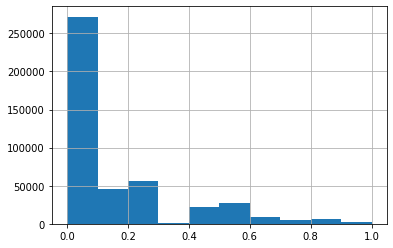

In [39]:
# Investigate data imbalance
data_top['toxicity'].hist()

In [49]:
toxic_num = len(data_top[data_top['toxicity']>0.5])
nontoxic_num = len(data_top[data_top['toxicity']<0.5])
print(f'Toxic ({toxic_num}) vs Non-Toxic ({nontoxic_num})')

Toxic (36000) vs Non-Toxic (397206)


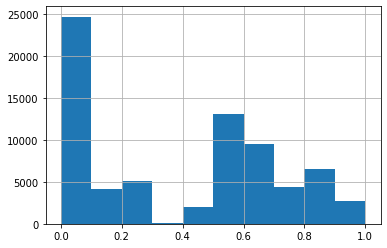

In [55]:
# Subsample larger class
num = min(toxic_num, nontoxic_num)
data_even = pd.concat([data_top[data_top['toxicity']<0.5].sample(num), data_top[data_top['toxicity']>0.5].sample(num)])
data_even['toxicity'].hist()

In [127]:
# Convert target to 1 & 0
data_even['target'] = data_even['toxicity'].apply(lambda x: 1 if x > 0.5 else 0)

In [ ]:
stop = stopwords.words('english')

In [94]:
data_even

,comment_text,toxicity,white
1649230,I am not a complete bigot against Christians a...,0.400000,0.0
1311177,There's very real irony in the story containin...,0.000000,0.0
1339250,I learned that material when I was in grade sc...,0.166667,0.0
1946973,"""The Catholic Church is for saints and sinners...",0.200000,0.0
1788134,It is shocking to see the G&M display it's bia...,0.000000,0.0
...,...,...,...
1324962,And you thought there weren't genocidal Buddhi...,0.600000,0.0
1341971,"""Western chauvinist"" = white racist.",0.700000,1.0
1395153,"""Noble motives""? \n\nBy a former member of th...",0.600000,0.0
401887,Since the lawyer can't defend what Menedez did...,0.631579,0.0


In [148]:
# Lowercase & Stop words & Tokenization
comment_text = data_even[text]
comment_text = comment_text.apply(lambda s: re.sub(r'[^\w]', ' ', s))
text_lower = comment_text.apply(lambda x: [item.lower() for item in x.split()])
text_stop = text_lower.apply(lambda x: [item for item in x if item not in stop])
text_token = text_stop.apply(lambda x: [word_tokenize(item)[0] for item in x])

In [149]:
text_token

1649230    [complete, bigot, christians, christianity, kn...
1311177    [real, irony, story, containing, pardeep, khun...
1339250    [learned, material, grade, school, long, time,...
1946973    [catholic, church, saints, sinners, alone, res...
1788134    [shocking, see, g, display, bias, end, report,...
                                 ...                        
1324962    [thought, genocidal, buddhist, extremists, gra...
1341971                 [western, chauvinist, white, racist]
1395153    [noble, motives, former, member, kgb, someone,...
401887     [since, lawyer, defend, menedez, use, race, ca...
600587     [majority, serial, killers, white, males, last...
Name: comment_text, Length: 72000, dtype: object

## Step 4 - Feature Generation

In [150]:
corpus = text_token.apply(lambda x: ' '.join(x)).tolist()

In [151]:
# TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', max_features=2000)
X = vectorizer.fit_transform(corpus)toarray()

In [152]:
# Visualize decomposition
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

In [153]:
pca_df = pd.DataFrame(data=pca_result, columns=['pca-one', 'pca-two'])
pca_df['target'] = data_even['target']

pca_df_pos = pca_df[pca_df['target'] == 1]
pca_df_neg = pca_df[pca_df['target'] == 0]

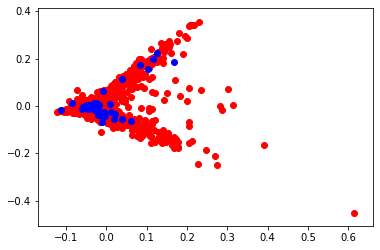

In [154]:
plt.scatter(pca_df_pos['pca-one'], pca_df_pos['pca-two'], color='r')
plt.scatter(pca_df_neg['pca-one'], pca_df_neg['pca-two'], color='b')

## Step 5 - Modelling Steps

In [178]:
data_all = pd.DataFrame(data=X, columns=[f'embed_{i}' for i in range(X.shape[1])])
data_all['target'] = data_even['target']

In [180]:
x_train, x, y_train, y = train_test_split(X,data_all['target'],test_size=0.3,train_size=0.7)
x_test, x_val, y_test, y_val = train_test_split(x,y,test_size=0.5,train_size=0.5)